## Cluster Tweets

Having some fun with tweets from my home timeline

In [1]:
import pandas as pd
import numpy as np
import pickle
import pymde
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table
import plotly.express as px
from keybert import KeyBERT

np.random.seed(11)


In [2]:
BASE_FPATH = 'data/nicktorba-embeddings-1618665255273660417-1621197610177466370'

with open(f"{BASE_FPATH}.pkl", "rb") as fIn:
    stored_data = pickle.load(fIn)
    df = pd.DataFrame(stored_data['records'])
    df.reset_index(inplace=True)
    encodings = stored_data['encodings']

df = df.drop_duplicates("clean_text")
encodings = encodings[df.index]

df = df.reset_index(drop=True)

### Drop encoding duplicates...
## TODO: Figure out which tweets have duplicate encodings... it's more complicated than having just the same clean_text field

encodings, indices, count = np.unique(encodings, axis=0, return_index=True, return_counts=True)

df = df.iloc[indices]

df = df.reset_index(drop=True)

print(df.shape)
print(encodings.shape)

(10176, 135)
(10176, 768)


## Num Tweets based on Communities Author Belongs to

Show a distribution of tweets that show the number of tweets that come for authors that are part of communities as assigned by Hive. 


In [ ]:
community_columns = [i for i in df.columns if i.startswith("communities.")]
community_array = df[community_columns].to_numpy()

grouped_df = pd.DataFrame({"sum": community_array.sum(axis=0), "community": [i.split(".")[1] for i in community_columns]})
grouped_df.sort_values(by="sum", ascending=False, inplace=True)

fig = px.bar(
        grouped_df.iloc[:15], 
        x="community", 
        y="sum", 
        color="community", 
        title=f"Tweets from the communities you follow ",
        text="sum"
    )

fig.show()

### Tweet Length Distribution

Show distribution of number of words in a tweet

"clean_text" field is tweet text with urls and @mentions removed 

In [4]:
import plotly.express as px
df["text.num_words"] = df["clean_text"].str.split().map(lambda x: len(x))
fig = px.histogram(df, x="text.num_words",nbins=50)

fig.show()

## Filter Dataset
You could do a lot here... for now I'm just excluding tweets with less than 7 words

In [5]:
MIN_NUM_WORDS = 6
df = df[df["text.num_words"] > MIN_NUM_WORDS]
print(df.shape)
encodings = encodings[df.index]
df.reset_index(drop=True, inplace=True)
print(f"{encodings.shape[0]} tweets with more than {MIN_NUM_WORDS} words")

(8585, 136)
8585 tweets with more than 6 words


In [6]:
### Drop encoding duplicates...

## TODO: Figure out which tweets have duplicate encodings... 
## There are still duplicates even after dropping tweets with the same 
## 'clean_text' field. Need to investigate why

encodings, indices, count = np.unique(encodings, axis=0, return_index=True, return_counts=True)
print(indices.shape)

df = df.iloc[indices]


(8585,)


In [7]:
print(encodings.shape)
print(df.shape)

(8585, 768)
(8585, 136)


## Cluster Tweets functions


1. Reduce dimensionality with pymde
    * why? our vectors are 768-d. hdbscan works well up to 100: [hdbscan docs](https://hdbscan.readthedocs.io/en/latest/faq.html#:~:text=In%20general%20HDBSCAN%20can%20do,it%20is%20no%20longer%20guaranteed.): 
> The most likely explanation is to do with the dimensionality of your input data. While HDBSCAN can perform well on low to medium dimensional data the performance tends to decrease significantly as dimension increases. In general HDBSCAN can do well on up to around 50 or 100 dimensional data, but performance can see significant decreases beyond that. Of course a lot is also dataset dependent, so you can still get good performance even on high dimensional data, but it is no longer guaranteed.
       
2. Hdbscan to cluster pymde embeddings

**important: cluster_selection_method="leaf"**
[docs here](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html?highlight=leaf%20cluster%20lab#allowing-a-single-cluster). 



3. Combine tweets from a cluster into a single corpus and extract keywords

4. Display in a table showing authors included in clsuter and the keywords to get a quick and dirty landscape view of the tweets in the dataset



In [8]:
def create_pymde_embeddings(df, encodings):
    """
    Use pymde (https://pymde.org/) to compress the vectors to 2-d data for plotting and clustering
    
    
    """
    pymde.seed(0) # get deterministic results: https://github.com/cvxgrp/pymde/issues/42
    mde = pymde.preserve_neighbors(encodings, verbose=False)
    pymde_encodings = mde.embed(verbose=False)
    
    df['x'] = [x * 10 for x, _ in pymde_encodings.tolist()]
    df['y'] = [y * 10 for _, y in pymde_encodings.tolist()]
    
    return df, pymde_encodings

def cluster_pymde_embeddings(
    df,  
    cluster_selection_method="leaf", 
    min_samples=10, 
    min_cluster_size=10,
    **hdbscan_kwargs
):
    clusterer = hdbscan.HDBSCAN(
        min_samples=min_samples, 
        min_cluster_size=min_cluster_size,
        cluster_selection_method=cluster_selection_method, 
        **hdbscan_kwargs
    )

    clusterer.fit(df[['x','y']])

    print(f"found {clusterer.labels_.max()} clusters!") # Number of clusters total. Cluster -1 is "no cluster"


    df['cluster'] = clusterer.labels_
    df['cluster_prob'] = clusterer.probabilities_
    return df, clusterer
    
def plot_clusters(df, clusterer):
    palette = sns.color_palette('husl', df['cluster'].max() + 1)

    def cluster_to_color(cluster, prob=0.7):
        if cluster == -1:
            return([125,125,125,0.4*255])
        colors = [o*255 for o in palette[cluster]]
        colors.append(prob*255)
        return(colors)

    df['color'] = [cluster_to_color(row[1].cluster, row[1].cluster_prob) for row in df.iterrows()]

    color_palette = sns.color_palette('deep', clusterer.labels_.max()+1)

    cluster_colors = [color_palette[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in clusterer.labels_]

    cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]

    obj = plt.scatter(x=df['x'], y=df['y'], s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
    
    
def authors_and_keywords(
    cluster_df,
    max_tweets=10,
    num_keywords=5,
    highlight_text=False,
    keyphrase_ngram_range=(1,2)
): 
    doc = ""
    for index, row in cluster_df.iterrows():
        doc += row.clean_text

    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range=keyphrase_ngram_range, top_n = num_keywords, highlight=highlight_text)
    keywords = ", ".join([i[0] for i in keywords])
    
    # authors = cluster_df["author.username"].value_counts().to_string()
    authors = ", ".join([f"{username}--{count}" for username, count in cluster_df["author_username"].value_counts().iteritems()])
    
    return authors, keywords

def create_cluster_table(df):
    table = Table(title="Clustered Tweets")
    table.add_column("Cluster", justify="right", style="cyan", no_wrap=True)
    table.add_column("Number of Tweets", style="red")
    table.add_column("Authors", style="magenta")
    table.add_column("KeyWords", justify="right", style="green")
    cluster_json = {}
    for i in range(8):
        cluster_df = cluster_df = df[df['cluster'] == i]
        cluster_json[i] = {}
        cluster_json[i]["ids"] = cluster_df["tweet_id"].unique().tolist()

        authors, keywords = authors_and_keywords(cluster_df)
        cluster_json[i]["keywords"] = keywords

        table.add_row(f"{i}", str(cluster_df.shape[0]), authors, keywords)
        table.add_row()

    console = Console()
    console.print(table)

### Cluster all Tweets

In [9]:
df, pymde_encodings = create_pymde_embeddings(df, encodings)


found 25 clusters!


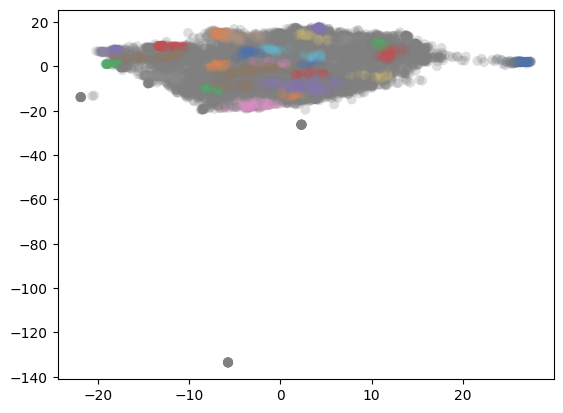

In [10]:
df, clusterer = cluster_pymde_embeddings(
    df,
    min_cluster_size=50,
    cluster_selection_method="leaf"
)
plot_clusters(df, clusterer)

In [11]:
create_cluster_table(df)

                                                 Clustered Tweets                                                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Cluster ┃ Number of Tweets ┃ Authors                                  ┃                                KeyWords ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       0 │ 143              │ statmlpapers--119, yudapearl--5,         │  learning prediction, prediction arxiv, │
│         │                  │ gusl--4, inferenceactive--2, tunguz--2,  │        learning large, learning models, │
│         │                  │ omarsar0--2, soniajoseph_--1,            │                        optimal learning │
│         │                  │ igorbrigadir--1, ricklamers--1,          │                                         │
│         │                  │ jamesthesnake--1, vboykis--1,            │                                         │
│         │                  │ nntaleb--1, nickadobos--1,               │                                         │
│         │                  │ wevolverapp--1, deepfates--1             │                                         │
│         │                  │                                          │                                         │
│       1 │ 328              │ visakanv--24, coscorrodrift--10,         │          follow twitter, twitter doing, │
│         │                  │ gptbrooke--10, igorbrigadir--9,          │      happening twitter, videos twitter, │
│         │                  │ sailaunderscore--9, deepfates--9,        │                           niche twitter │
│         │                  │ strangestloop--8, tunguz--7,             │                                         │
│         │                  │ reddy2go--6, goblinodds--6,              │                                         │
│         │                  │ duderichy--6, joodaloop--6,              │                                         │
│         │                  │ theinformation--6, parafactual--5,       │                                         │
│         │                  │ alexllulltw--5, danielleboccell--5,      │                                         │
│         │                  │ normonics--5, richdecibels--5, _inju--5, │                                         │
│         │                  │ startingfromnix--5, _swaghercules--5,    │                                         │
│         │                  │ andtoddsaid--4, lifemathmoney--4,        │                                         │
│         │                  │ alinatheripper--4, kaseyklimes--4,       │                                         │
│         │                  │ amasad--4, yhdistyminen--4,              │                                         │
│         │                  │ m_ashcroft--4, tautologer--4,            │                                         │
│         │                  │ tyleralterman--4, p_millerd--4,          │                                         │
│         │                  │ yashkaf--3, katrinadlc--3,               │                                         │
│         │                  │ sun_girlxo--3, gggonemad--3,             │                                         │
│         │                  │ tasshinfogleman--3, ungatedcreative--3,  │                                         │
│         │                  │ alexyoungkwon--3, doriantaylor--3,       │                                         │
│         │                  │ blisstweeting--3, ollyrobot--3,          │                                         │
│         │                  │ blackmagic_so--3, dschorno--3,           │                                         │
│         │                  │ austen--2, mitsuhiko--2, posobin--2,     │                                         │
│         │                  │ amirism_--2, rqasim13--2,

## Smaller Clusters
Compare the effect of min_cluster_size to the run above

found 64 clusters!


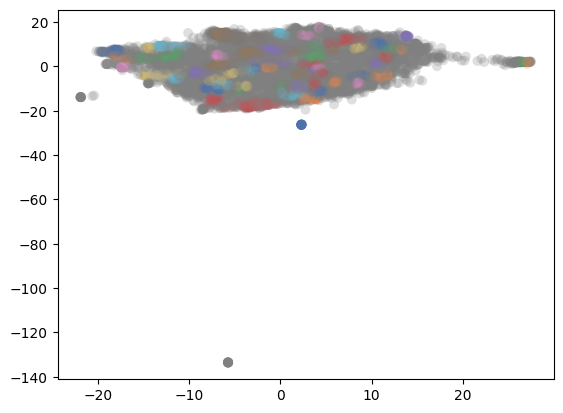

In [21]:
df, clusterer = cluster_pymde_embeddings(
    df,
    min_cluster_size=20,
    cluster_selection_method="leaf"
)
plot_clusters(df, clusterer)

In [22]:
create_cluster_table(df)

                                                 Clustered Tweets                                                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Cluster ┃ Number of Tweets ┃ Authors                                  ┃                                KeyWords ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       0 │ 23               │ culturaltutor--23                        │   munch artistic, munch art, art munch, │
│         │                  │                                          │   impressionists munch, painting scream │
│         │                  │                                          │                                         │
│       1 │ 22               │ statmlpapers--22                         │     optimal transport, policy gradient, │
│         │                  │                                          │         discontinuous optimal, entropic │
│         │                  │                                          │          optimal, robustness guarantees │
│         │                  │                                          │                                         │
│       2 │ 44               │ statmlpapers--43, inferenceactive--1     │         deep learning, tensor networks, │
│         │                  │                                          │         learning models, learning deep, │
│         │                  │                                          │                   bayesian hierarchical │
│         │                  │                                          │                                         │
│       3 │ 37               │ _swaghercules--10, dschorno--2,          │ does floyd, floyd throw, conor, pereira │
│         │                  │ drcamrx--2, cxgonzalez--1, visakanv--1,  │                  rounds, mcgregor crazy │
│         │                  │ malcolm_ocean--1, deepfates--1,          │                                         │
│         │                  │ minhwrites--1, duilen--1,                │                                         │
│         │                  │ scrapbookhattie--1, coscorrodrift--1,    │                                         │
│         │                  │ yehudisum--1, pablomuralo--1, tunguz--1, │                                         │
│         │                  │ lifemathmoney--1, mold_time--1,          │                                         │
│         │                  │ davidvorick--1, lukeburgis--1, conaw--1, │                                         │
│         │                  │ makanidotspace--1, normonics--1,         │                                         │
│         │                  │ waitbutwhy--1, barakplasma--1,           │                                         │
│         │                  │ nikmilanovic--1, andtoddsaid--1,         │                                         │
│         │                  │ tyleralterman--1                         │                                         │
│         │                  │                                          │                                         │
│       4 │ 26               │ doriantaylor--11, mitsuhiko--4,          │        rust symbolic, rust update, rust │
│         │                  │ thisiswhyicode--3, ollyrobot--2,         │             syntax, api rust, rust code │
│         │                  │ igorbrigadir--1, deepfates--1,           │                                         │
│         │                  │ cxgonzalez--1, empathy2000--1,           │                                         │
│         │                  │ davidvorick--1, coscorrodrift--1         │                                         │
│         │                  │                                          │                                         │
│       5 │ 328              │ visakanv--24, coscorrodri

### TPOT Cluster

4305 tweets in cluster


/tmp/ipykernel_57924/3365212317.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57924/3365212317.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57924/3365212317.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

found 13 clusters!


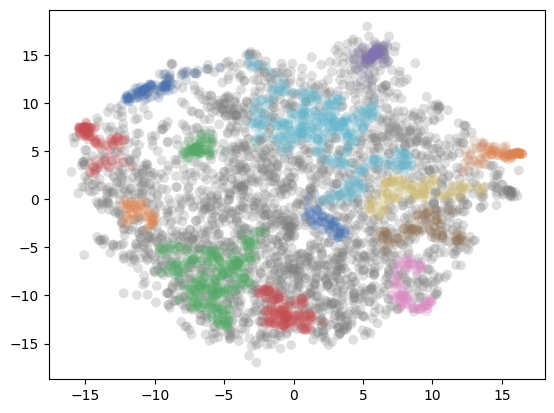

In [12]:
tpot_df = df[df["communities.Rationalism & TPOT"] == 1]
tpot_encodings = encodings[tpot_df.index]

print(f"{tpot_df.shape[0]} tweets in cluster")

tpot_df, pymde_encodings = create_pymde_embeddings(tpot_df, tpot_encodings)
tpot_df, clusterer = cluster_pymde_embeddings(
    tpot_df,
    min_cluster_size=50,
    cluster_selection_method="leaf"
)
plot_clusters(tpot_df, clusterer)

In [13]:
create_cluster_table(tpot_df)

                                                 Clustered Tweets                                                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Cluster ┃ Number of Tweets ┃ Authors                                 ┃                                 KeyWords ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       0 │ 107              │ yhdistyminen--27, duderichy--12,        │  build vancouver, vancouver zoning, city │
│         │                  │ devonzuegel--10, coscorrodrift--6,      │                      comfort, sf, sf bay │
│         │                  │ nickcammarata--3, gptbrooke--3,         │                                          │
│         │                  │ _stevenfan--3, tasshinfogleman--3,      │                                          │
│         │                  │ christineist--2, p_millerd--2,          │                                          │
│         │                  │ theannagat--2, andy_matuschak--2,       │                                          │
│         │                  │ tautologer--2, jc_erde--2, austen--2,   │                                          │
│         │                  │ tszzl--2, richdecibels--2,              │                                          │
│         │                  │ benefic_venefic--2, joespurpleshirt--1, │                                          │
│         │                  │ sailaunderscore--1, goblinodds--1,      │                                          │
│         │                  │ prigoose--1, reddy2go--1, gggonemad--1, │                                          │
│         │                  │ katrinadlc--1, gusl--1, tkpullinger--1, │                                          │
│         │                  │ dschorno--1, makanidotspace--1,         │                                          │
│         │                  │ deepfates--1, sheslostheplot--1,        │                                          │
│         │                  │ leahprime--1, augurydefier--1,          │                                          │
│         │                  │ aella_girl--1, isabelunraveled--1,      │                                          │
│         │                  │ cxgonzalez--1, alexeyguzey--1,          │                                          │
│         │                  │ jamesthesnake--1                        │                                          │
│         │                  │                                         │                                          │
│       1 │ 88               │ andtoddsaid--24, igorbrigadir--8,       │  medley numb, numb copy, haven listened, │
│         │                  │ coscorrodrift--8, deepfates--6,         │               metal harmonies, daft punk │
│         │                  │ richdecibels--5, augurydefier--3,       │                                          │
│         │                  │ goblinodds--3, benefic_venefic--2,      │                                          │
│         │                  │ visakanv--2, dschorno--2, dela3499--2,  │                                          │
│         │                  │ theannagat--2, m_ashcroft--2,           │                                          │
│         │                  │ leahprime--1, aella_girl--1,            │                                          │
│         │                  │ malcolm_ocean--1, gbrl_dick--1,         │                                          │
│         │                  │ prigoose--1, sailaunderscore--1,        │                                          │
│         │                  │ duderichy--1, notesbyalake--1,          │                                          │
│         │                  │ yhdistyminen--1, interintellect_--1,    │                                          │
│         │                  │ coladaclan--1, christinei

### Venture Capital 

found 5 clusters!


/tmp/ipykernel_57924/3365212317.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57924/3365212317.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57924/3365212317.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

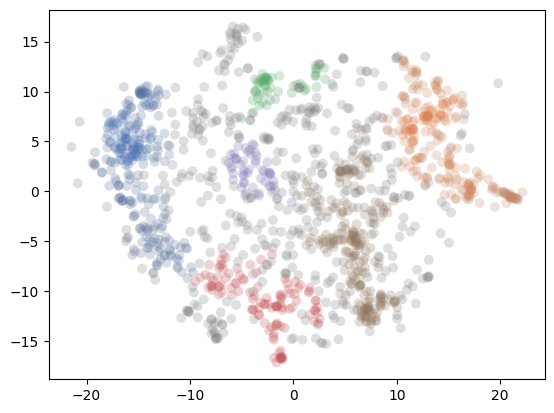

In [14]:
vc_df = df[df["communities.Venture Capital"] == 1]
vc_encodings = encodings[vc_df.index]


vc_df, pymde_encodings = create_pymde_embeddings(vc_df, vc_encodings)
vc_df, clusterer = cluster_pymde_embeddings(
    vc_df,
    min_cluster_size=50,
    cluster_selection_method="leaf"
)
plot_clusters(vc_df, clusterer)

In [15]:
create_cluster_table(vc_df)

                                                 Clustered Tweets                                                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Cluster ┃ Number of Tweets ┃ Authors                                  ┃                                KeyWords ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       0 │ 260              │ isabelunraveled--44,                     │    frantic reading, feels performative, │
│         │                  │ startingfromnix--34, drcamrx--30,        │    reading experience, thoughts moment, │
│         │                  │ theannagat--21, interintellect_--20,     │                         having thoughts │
│         │                  │ noampomsky--11, sheslostheplot--8,       │                                         │
│         │                  │ simonsarris--8, lucy_guo--7, conaw--7,   │                                         │
│         │                  │ krishnanrohit--6, paulg--4,              │                                         │
│         │                  │ leo_guinan--4, micsolana--4,             │                                         │
│         │                  │ lauralondon_--4, alexyoungkwon--4,       │                                         │
│         │                  │ austen--4, sarahkunst--3, posobin--3,    │                                         │
│         │                  │ patriciamou_--3, prigoose--3,            │                                         │
│         │                  │ iamjasonlevin--2, sariazout--2,          │                                         │
│         │                  │ sparksremarks--2, rhyslindmark--2,       │                                         │
│         │                  │ balajis--2, teej_m--2,                   │                                         │
│         │                  │ makanidotspace--2, patio11--2,           │                                         │
│         │                  │ packym--1, minney_cat--1, ianvanagas--1, │                                         │
│         │                  │ startupyworld--1, tylerangert--1,        │                                         │
│         │                  │ pavel_asparagus--1, krishkhubchand--1,   │                                         │
│         │                  │ jasoncbenn--1, victor_patru--1,          │                                         │
│         │                  │ nastassiapo--1, nikmilanovic--1,         │                                         │
│         │                  │ ashitaa--1                               │                                         │
│         │                  │                                          │                                         │
│       1 │ 236              │ theinformation--55, acquiredotcom--36,   │       fundraising milestones, companies │
│         │                  │ nikmilanovic--16, alexyoungkwon--10,     │   celebrating, business trends, revenue │
│         │                  │ krishnanrohit--10, dteten--10,           │                soared, interesting data │
│         │                  │ patio11--10, austen--9, sarahkunst--8,   │                                         │
│         │                  │ leo_guinan--7, theannagat--5,            │                                         │
│         │                  │ neilthanedar--4, jessewldn--4,           │                                         │
│         │                  │ j_austincain--4, startingfromnix--4,     │                                         │
│         │                  │ lucy_guo--3, paulg--3, jessepollak--3,   │                                         │
│         │                  │ balajis--3, posobin--3, justjake--2,     │                                         │
│         │                  │ teej_m--2, micsolana--2, 

### YC 

1156 tweets from YC cluster
found 3 clusters!


/tmp/ipykernel_57924/3365212317.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57924/3365212317.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57924/3365212317.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

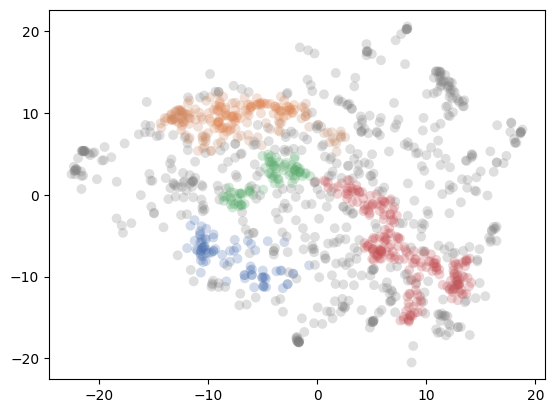

In [16]:
yc_df = df[df["communities.YC"] == 1]
yc_encodings = encodings[yc_df.index]


print(f"{yc_df.shape[0]} tweets from YC cluster")

yc_df, pymde_encodings = create_pymde_embeddings(yc_df, yc_encodings)
yc_df, clusterer = cluster_pymde_embeddings(
    yc_df,
    min_cluster_size=50,
    cluster_selection_method="leaf"
)
plot_clusters(yc_df, clusterer)

In [17]:
create_cluster_table(yc_df)

                                                 Clustered Tweets                                                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Cluster ┃ Number of Tweets ┃ Authors                                 ┃                                 KeyWords ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       0 │ 81               │ visakanv--38, yashkaf--6, duderichy--5, │ twitter opportunities, daysports fandom, │
│         │                  │ alexyoungkwon--5, krishnanrohit--3,     │ thinking twitter, niche twitter, twitter │
│         │                  │ tszzl--3, tyleralterman--3,             │                                       hq │
│         │                  │ ryandawidjan--2, austen--2,             │                                          │
│         │                  │ prigoose--2, startingfromnix--1,        │                                          │
│         │                  │ lucy_guo--1, petesoder--1,              │                                          │
│         │                  │ geoffreylitt--1, nickcammarata--1,      │                                          │
│         │                  │ thecaptain_nemo--1, alexeyguzey--1,     │                                          │
│         │                  │ sarahkunst--1, noampomsky--1,           │                                          │
│         │                  │ micsolana--1, teej_m--1, mold_time--1   │                                          │
│         │                  │                                         │                                          │
│       1 │ 200              │ visakanv--65, startingfromnix--23,      │     mindedness incumbents, time insight, │
│         │                  │ tyleralterman--22, nickcammarata--17,   │   believe economic, economic commentary, │
│         │                  │ krishnanrohit--10, conaw--8, tszzl--6,  │                    incumbents especially │
│         │                  │ micsolana--5, noampomsky--5,            │                                          │
│         │                  │ thecaptain_nemo--5, austen--4,          │                                          │
│         │                  │ lauralondon_--4, yashkaf--4,            │                                          │
│         │                  │ sarahkunst--3, duderichy--3,            │                                          │
│         │                  │ alexyoungkwon--3, patio11--2,           │                                          │
│         │                  │ lucy_guo--2, paulg--2,                  │                                          │
│         │                  │ fanswitchboard--2, krishkhubchand--1,   │                                          │
│         │                  │ alexeyguzey--1, pavel_asparagus--1,     │                                          │
│         │                  │ patriciamou_--1, geoffreylitt--1        │                                          │
│         │                  │                                         │                                          │
│       2 │ 81               │ visakanv--39, paulg--6,                 │            imaginations curiosities, say │
│         │                  │ tyleralterman--6, startingfromnix--5,   │   articulating, articulating, philosophy │
│         │                  │ duderichy--4, krishnanrohit--3,         │             artistic, feels performative │
│         │                  │ nickcammarata--2, krishkhubchand--2,    │                                          │
│         │                  │ patio11--2, noampomsky--2,              │                                          │
│         │                  │ micsolana--2, nikmilanovic--1,          │                                          │
│         │                  │ fanswitchboard--1, patric

### Second Order clustering

Take a large cluster and cluster the tweets again... 
The results are pretty great. 

TODO: compare this to running with a smaller min_cluster_size and see if it finds the same ones


This could create a cool zooming UI/UX... find large cluster (of size >=100, choose one, then cluster again, again, until you get to a set of 10 tweets that the user actually wants to look at) 



200 tweets from YC community, cluster 1
found 6 clusters!


/tmp/ipykernel_57924/3365212317.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57924/3365212317.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_57924/3365212317.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

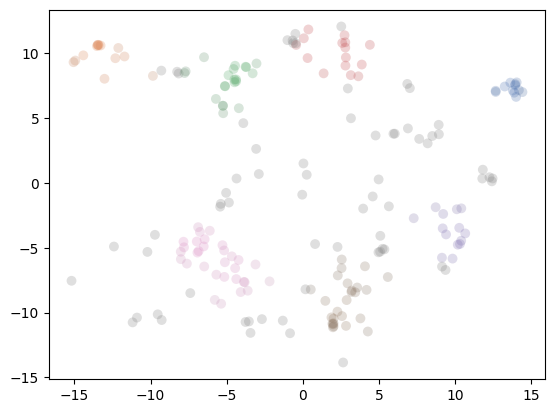

In [18]:
yc_c1_df = yc_df[yc_df["cluster"] == 1]
yc_c1_encodings = encodings[yc_c1_df.index]

print(f"{yc_c1_df.shape[0]} tweets from YC community, cluster 1")

yc_c1_df, _ = create_pymde_embeddings(yc_c1_df, yc_c1_encodings)
yc_c1_df, clusterer = cluster_pymde_embeddings(
    yc_c1_df,
    min_cluster_size=5,
    cluster_selection_method="leaf"
)
plot_clusters(yc_c1_df, clusterer)

In [19]:
create_cluster_table(yc_c1_df)

                                                 Clustered Tweets                                                  
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Cluster ┃ Number of Tweets ┃ Authors                                  ┃                                KeyWords ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       0 │ 12               │ nickcammarata--2, tyleralterman--2,      │   rationalists generally, rationalists, │
│         │                  │ conaw--1, sarahkunst--1, micsolana--1,   │  rationalists major, know rationalists, │
│         │                  │ alexyoungkwon--1, krishnanrohit--1,      │                       tweeting rational │
│         │                  │ tszzl--1, duderichy--1,                  │                                         │
│         │                  │ thecaptain_nemo--1                       │                                         │
│         │                  │                                          │                                         │
│       1 │ 13               │ lauralondon_--3, lucy_guo--2,            │   regular adderall, adderall use, eased │
│         │                  │ micsolana--2, visakanv--2,               │       coke, adderall, miracle ibuprofen │
│         │                  │ tyleralterman--1, paulg--1,              │                                         │
│         │                  │ thecaptain_nemo--1, geoffreylitt--1      │                                         │
│         │                  │                                          │                                         │
│       2 │ 21               │ visakanv--7, nickcammarata--5,           │    anxious uneasy, insight perspective, │
│         │                  │ startingfromnix--4, tszzl--2,            │        nervous feels, insight practice, │
│         │                  │ patio11--1, sarahkunst--1,               │                                 anxiety │
│         │                  │ tyleralterman--1                         │                                         │
│         │                  │                                          │                                         │
│       3 │ 15               │ nickcammarata--4, tyleralterman--3,      │             mathematics transcendental, │
│         │                  │ krishnanrohit--2, yashkaf--2, conaw--2,  │          transcendental cult, promising │
│         │                  │ lauralondon_--1, visakanv--1             │         mathematicians, transcendental, │
│         │                  │                                          │                   mathematicians better │
│         │                  │                                          │                                         │
│       4 │ 14               │ visakanv--8, micsolana--2,               │     poverty larper, poverty, repentance │
│         │                  │ thecaptain_nemo--1, conaw--1,            │       praise, sinner repents, righteous │
│         │                  │ alexeyguzey--1, tszzl--1                 │                                 persons │
│         │                  │                                          │                                         │
│       5 │ 26               │ visakanv--8, noampomsky--5,              │      truth depression, depression, food │
│         │                  │ startingfromnix--5, tyleralterman--2,    │         critic, depression people, cook │
│         │                  │ austen--2, patriciamou_--1, conaw--1,    │                                         │
│         │                  │ krishnanrohit--1, alexyoungkwon--1       │                                         │
│         │                  │                                          │                                         │
│       6 │ 31               │ visakanv--11, startingfro

### Some Takeaways

* the parameters for dbscan, min_samples and min_cluster_size have a massive effect on the resulting clusters. Too large, and all the data is categorized together. Too small, and there is an insane amount of clusters... (although, for what I find most interesting, this is the better scenario to run into) 

* cluster_selection_method='leaf' was MASSIVELY important for getting better results. The default 'eom' almost always led to the identification of a single massive cluster 

* It would be best to spend time really understanding PYMDE

* I should experiment with twitter specific language models, instead of the general BERT model (although the results are already pretty impressive without this) 

